In [2]:
import numpy as np
import torch_geometric as tg
import seaborn as sns
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, global_add_pool, GraphConv
import torch.nn.functional as F
import pandas as pd
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
from dataset_gen import one_hot_generator
#device=torch.device('cpu')

/home/dinverno/anaconda3/envs/gnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
batch_size = 72

#num_layers = [1,2,3,4,5,6,7,8,9,10]
num_layers = [1,2,3]
lr = 0.0025
epochs = 5000



In [4]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, nc):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(nc):
            self.convs.append(GraphConv(in_channels, hidden_channels, aggr='add', bias=True))
            in_channels = hidden_channels

        # TODO: No dropout.
        self.mlp = MLP([hidden_channels, hidden_channels, out_channels])

    def forward(self, x, edge_index, batch):
        for conv in self.convs:
            x = torch.relu(conv(x, edge_index))
        x = global_add_pool(x, batch)

        return torch.sigmoid(self.mlp(x))

In [8]:

num_reps = 2
raw_data = []
hd = 16
num_layers=[1]

In [9]:
colors = ["darkorange", "royalblue", "darkorchid"]
for l in num_layers:
    for it in range(num_reps):
        torch_geometric.seed.seed_everything(it*100)
        data_dict = one_hot_generator()
        train_loader = data_dict['train_loader']
        test_loader = data_dict['test_loader']
        xy = data_dict['xy']
        #seed manual setting
        
        


        model = Net(26, hd, 1, l).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        @torch.enable_grad()
        def train():
            model.train()

            total_loss = 0
            for data in train_loader:
                data = data.to(device)
                optimizer.zero_grad()
                out = model(data.x, data.edge_index, data.batch)
                loss = F.binary_cross_entropy(out, data.y)
                
                #loss = F.cross_entropy(out, data.y)
                loss.backward()
                optimizer.step()
                total_loss += float(loss) * data.num_graphs
            return total_loss / len(train_loader.dataset)


        @torch.no_grad()
        def test(loader):
            model.eval()

            total_correct = 0
            for data in loader:
                data = data.to(device)
                pred = model(data.x, data.edge_index, data.batch) 
                
                loss = F.binary_cross_entropy(pred, data.y)

                pred = pred > 0.5
                total_correct += int((pred == data.y).sum())
            return total_correct * 100 / len(loader.dataset), loss.item()


        for epoch in range(1, epochs + 1):
            print('Epoch: '+str(epoch))
            loss = train()          
            train_acc, train_loss= test(train_loader)       
            test_acc, test_loss = test(test_loader) 



            raw_data.append({'train_acc': train_acc, 'train_loss': train_loss, 'test_acc': test_acc,
                             'test_loss': test_loss,  'epoch': epoch, 'it': it,'num_layer':l})
    
    data = pd.DataFrame.from_records(raw_data)
    data.to_csv('trial_14_feb')

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
Epoch: 1

In [14]:
xy.to(device)
float(model(xy.x, xy.edge_index, xy.batch))

1.0638977983035147e-05

: 

In [13]:
aa = data_dict['AA'].to(device)
float(model(aa.x, aa.edge_index, aa.batch))

0.9999899864196777

In [25]:
test_loss_history = data['test_loss'].values
epochs = data['epoch'].values


<AxesSubplot:xlabel='epoch', ylabel='test_loss'>

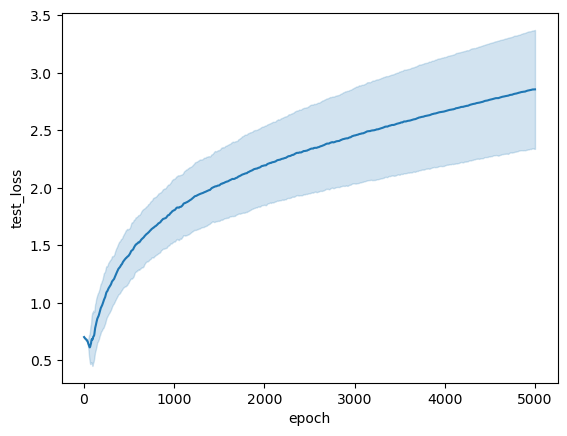

In [11]:
sns.lineplot(data=data, x='epoch', y='test_loss')

In [12]:
float(loss)

1.4109025869402103e-05

In [1]:
from dataset_gen import dataset_generator

/home/dinverno/anaconda3/envs/gnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_generator('distributed')

{'xy': Data(x=[2, 26], edge_index=[2, 1], y=[1, 1]),
 'AA': Data(x=[2, 26], edge_index=[2, 1], y=[1, 1]),
 'YY': Data(x=[2, 26], edge_index=[2, 1], y=[1, 1]),
 'ZZ': Data(x=[2, 26], edge_index=[2, 1], y=[1, 1]),
 'YZ': Data(x=[2, 26], edge_index=[2, 1], y=[1, 1]),
 'ZT': Data(x=[2, 26], edge_index=[2, 1], y=[1, 1]),
 'EY': Data(x=[2, 26], edge_index=[2, 1], y=[1, 1]),
 'SZ': Data(x=[2, 26], edge_index=[2, 1], y=[1, 1]),
 'train_loader': <torch_geometric.loader.dataloader.DataLoader at 0x7f03a8913340>,
 'test_loader': <torch_geometric.loader.dataloader.DataLoader at 0x7f03a8913400>}

In [3]:
dictio = dataset_generator('distributed')


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0.]])

In [10]:
import networkx as nx
import numpy as np
import torch

In [11]:

def cycle_graph(n):
    A = np.zeros((n,n))
    A[0,-1]=1
    A[-1,0]=1
    for i in range(n-1):
        A[i,i+1]=1
        A[i+1,i]=1
    return A



In [12]:

def bipolar_graph(m,n):
    A_1 = cycle_graph(m)
    A_2 = cycle_graph(n)
    A = np.zeros((m+n,m+n))
    A[:m,:m] = A_1
    A[m:,m:] = A_2
    A[m,m-1] = 1
    A[m-1,m] = 1
    return A

In [18]:

A = bipolar_graph(5,5)
G = nx.from_numpy_matrix(A)
nx.set_node_attributes(G, [1 for _ in range(5)])
# from torch_geometric.utils import from_networkx
# g = from_networkx(G)
# g.y = 0



AttributeError: 'list' object has no attribute 'items'

In [1]:
from dataset_gen import dataset_generator

/home/dinverno/anaconda3/envs/gnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data_dict = dataset_generator('haar')

/home/dinverno/Scrivania/identity_effects_GNN/dataset_gen.py:129: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/utils/tensor_new.cpp:210.)
  x_correct = torch.tensor([encodings[k], encodings[k]], dtype=torch.float)


[[0], [1], [2], [3], [4]]

In [27]:
from dataset_gen import dataset_generator, get_complete_dataset_gap
import torch
import matplotlib.pyplot as plt
from torch_geometric.nn import GraphConv, WLConv
from torch_geometric.utils.convert import to_networkx
import networkx as nx
from utils import node_position

device = torch.device('cpu')
#('cuda:1' if torch.cuda.is_available() else 'cpu')


class WL(torch.nn.Module):
    def __init__(self,  num_it):
        super().__init__()
        self.num_it = num_it
        self.conv = WLConv()

    def forward(self, x, edge_index):
        for _ in range(self.num_it):
            x = self.conv(x, edge_index)
        pred = x-torch.min(x)
        pred, _, count = torch.unique(pred, return_inverse= True, return_counts = True)
        pred = torch.stack([pred,count])
        if 1 in count:
            y = 0
        else:
            y = 1
        return pred, y

    def reset_parameters(self):
        return self.conv.reset_parameters()





## Graph drawing

In [4]:
from dataset_gen import dicyclic_data
from utils import node_position
from torch_geometric.utils.convert import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
m = 4
n = 6
data = dicyclic_data(m,n)
g = to_networkx(data, to_undirected=True)
pos = node_position(m,n)
nx.draw_net(g, pos=pos)
plt.axis('equal')
#pred, y = model(data.x, data.edge_index)

# pred, _, count = torch.unique(data.edge_index[0], return_inverse= True, return_counts = True)
# pred = torch.stack([pred,count])
# print(pred)

# plt.hist(pred)
# plt.show()


TypeError: '_AxesStack' object is not callable

<Figure size 640x480 with 0 Axes>

In [29]:
import seaborn as sns
from dataset_gen import all_bipolar
import pandas as pd
n_max = 10
gap =6
data_dict = get_complete_dataset_gap(n_max, gap)


train_loader = data_dict['train_loader']
model = WL(16)
model.eval()

# data_list = []
# for i, data in enumerate(train_loader):
#     data_list.append(data)
    #data = data.to(device)
model.reset_parameters()
data_loader = data_dict['test_loader_nobatch']
raw_data = []
iter_dl = iter(data_loader)
for i in range(3,n_max+gap+1):
    for j in range(i,n_max+gap+1):
        data = next(iter_dl)
        pred,y = model(data.x, data.edge_index)
        
        raw_data.append({'1st_cycle':i,'2nd_cycle':j,'rating': y})
        if j!=i:
            raw_data.append({'1st_cycle':j,'2nd_cycle':i,'rating': y})



<function matplotlib.pyplot.show(close=None, block=None)>

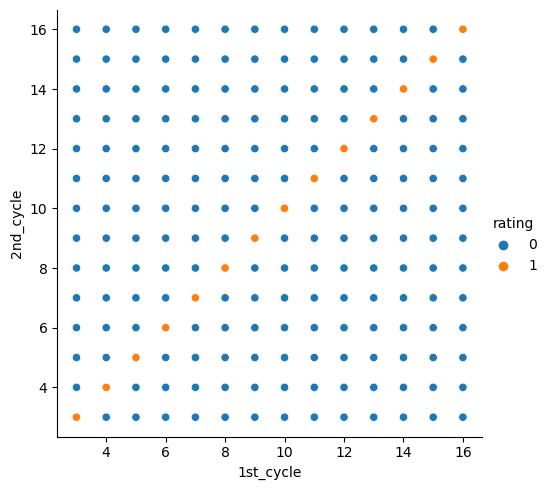

In [30]:
df = pd.DataFrame.from_records(raw_data)
sns.relplot(data=df, x = '1st_cycle', y = '2nd_cycle', hue = 'rating')
plt.show

In [1]:
from dataset_gen import dataset_generator
import torch
import matplotlib.pyplot as plt
from torch_geometric.nn import GraphConv, WLConv
from torch_geometric.utils.convert import to_networkx
import networkx as nx

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

n_max = 14
data_dict = dataset_generator(dataset='bipolar', n_max = n_max)

train_loader = data_dict['train_loader']



class WL(torch.nn.Module):
    def __init__(self,  num_it):
        super().__init__()
        self.num_it = num_it
        self.conv = WLConv()

    def forward(self, x, edge_index):
        for _ in range(self.num_it):
            x = self.conv(x, edge_index)
        
        return x

    def histogram(self,x):
        return self.conv.histogram(x)
    
    def reset_parameters(self):
        return self.conv.reset_parameters()

model = WL(20)
#model = WLConv()
model.eval()

data_list = []
for i, data in enumerate(train_loader):
    data_list.append(data)
    #data = data.to(device)

from torch_geometric.utils import index_to_mask




    


/home/dinverno/anaconda3/envs/gnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
t = data_list[0].edge_index
x = data_list[0].x
msk = index_to_mask(t)


In [5]:
t = data_list[0].edge_index
a,b,c = torch.unique(t[0], return_inverse= True, return_counts = True)

In [2]:
a = data_dict['3_3']


In [7]:
next(iter(a))

DataBatch(edge_index=[2, 14], weight=[14], num_nodes=6, x=[6, 1], y=[1, 1], batch=[6], ptr=[2])

In [11]:
print(data_list[0].x.size())

torch.Size([892, 1])


In [1]:
import pandas as pd



In [14]:
df = pd.read_csv('trial_nmax_8_gap_8_10_layers.csv', )
list_col = df.columns
list_col = list_col.drop(df.columns[0])
df = df[list_col]




In [23]:
import json
with open('params.json') as f:
        params = json.load(f)
n_max = params['n_max']
gap = params['gap']
list_red = []
for i in range(3,n_max+gap+1):
    for j in range(3,n_max+gap+1):
        df_red = df[df['1st_cycle']==i]
        df_red = df_red[df_red['2nd_cycle']==j]

        rating_std = df_red['rating'].std()
        rating_mean = df_red['rating'].mean()
        list_red.append({'1st_cycle':i, '2nd_cycle':j, 'rating':rating_mean, 'std': rating_std})


        

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

/home/dinverno/anaconda3/envs/gnn_id/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
a = torch.tensor([[1,2,5,6]], dtype = torch.float32)
b = torch.tensor([[0,-1,0,1/3]], dtype = torch.float32)
torch.dot(torch.squeeze(a),torch.squeeze(b)).item()

0.0

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('orthogonality/20_03_23/gconv/trial_1/10hidden_features.csv')[['1st_cycle','2nd_cycle','hidd']]

In [23]:
A = np.loadtxt('orthogonality/21_03_23/gconv_glob/trial_1/12_scalar_products.txt')

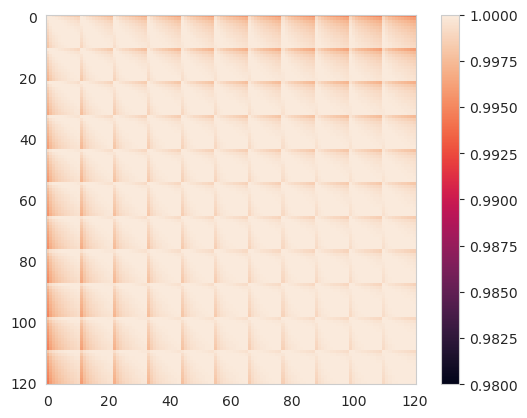

In [29]:
plt.figure()
sns.set_style("whitegrid")
plt.imshow(A.T)
ax = plt.gca()
plt.grid(False)
plt.colorbar()
plt.clim(0.98, 1)


# 31 marzo 2023
## Prova plot

Proposta Simone: calcolare $\max_{n,q}$ e $avg_{n,q}$ tra prodotto scalare $C_m^n$ e $C_p^q$

In [73]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
gnn_type = 'gconv_diff'
hidden_x1 = torch.load('orthogonality/01_04_23/'+gnn_type+'/trial_4/12hidden_x1.pt')
hidden_x2 = torch.load('orthogonality/01_04_23/'+gnn_type+'/trial_4/12hidden_x2.pt')
n_max = 8
gap = 5
n_graphs = n_max+gap-2
sp = torch.zeros((n_graphs,n_graphs))
for m in range(0, n_graphs):
    for p in range(0, n_graphs):
        sp_list = []
        for n in range(0, n_graphs):
            for q in range(0, n_graphs):
                x1 = hidden_x1[m,n,:]/torch.norm(hidden_x1[m,n,:])
                x2 = hidden_x2[q,p,:]/torch.norm(hidden_x2[q,p,:])
                sp_list.append(torch.dot(x1,x2))
        sp[m,p] = torch.max(torch.tensor(sp_list))
#torch.save(sp, 'orthogonality/22_03_23/'+gnn_type+'/trial_2/avg_scalar_products.pt')

In [75]:
A = sp.numpy()


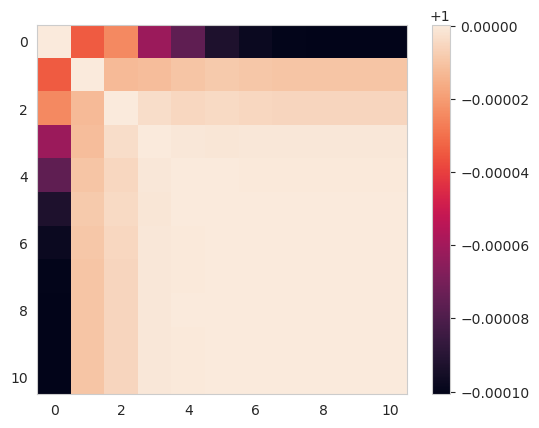

In [76]:
plt.figure()
sns.set_style("whitegrid")
plt.imshow(A.T)
ax = plt.gca()
plt.grid(False)
plt.colorbar()
plt.clim(np.min(A),np.max(A))

In [56]:
torch.max(hidden_x1[8,10,:]-hidden_x2[10,8,:])

tensor(5.9605e-08, grad_fn=<MaxBackward1>)

In [57]:
np.min(A)

1.0

# 24 Aprile: Weight analysis

In [1]:
import torch
import os
import torch
import torch_geometric
import numpy as np
import pandas as pd
from models import *

/home/dinverno/anaconda3/envs/gnn_id/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
input = 1
hd = 200
num_l = 13
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
m1 = GCONVDIFF(input, hd, 1, num_l).to(device)
m2 = GCONVDIFF(input, hd, 1, num_l).to(device)

In [5]:
#m1.load_state_dict(torch.load('words/general/25_04_23/gconv_diff_words/trial_0/model_state/epoch2500_model_state_one-hot.pt'))
#m2.load_state_dict(torch.load('words/general/25_04_23/gconv_diff_words/trial_0/model_state/epoch1500_model_state_one-hot.pt'))

m1.load_state_dict(torch.load('cycles/orthogonality/gap/25_04_23/gconv_diff/trial_0/model_state/epoch1500_model_state_dicyclic.pt'))
m1.load_state_dict(torch.load('cycles/orthogonality/gap/25_04_23/gconv_diff/trial_0/model_state/epoch2500_model_state_dicyclic.pt'))

<All keys matched successfully>

In [8]:
m1.state_dict()['convs.5.lin_rel.weight']-m2.state_dict()['convs.5.lin_rel.weight']


tensor([[-0.0154, -0.0100, -0.0402,  ..., -0.0114,  0.0527,  0.0448],
        [ 0.1036, -0.0249,  0.0393,  ..., -0.0107,  0.0878, -0.1254],
        [ 0.0244,  0.0058, -0.0340,  ...,  0.0229,  0.0818, -0.0303],
        ...,
        [-0.0592, -0.0432,  0.0346,  ..., -0.0061, -0.0437, -0.0072],
        [ 0.1062,  0.0585, -0.0095,  ...,  0.0758, -0.0017, -0.0103],
        [-0.0125,  0.1072, -0.0569,  ...,  0.0385,  0.0472,  0.0049]],
       device='cuda:0')

: 

In [3]:
for item in model.state_dict():
    print(item)

NameError: name 'model' is not defined